# Hatree Fock Calculation
#I know that DFT method much better, but I have to use more prooved and sophisticated libraries for MO enegries

**FC = eSC**    # **e**-energy eigenvalues,  **S**-overlaping matrix for orbitals and **C** matric of molecular orbital(row is atomic orbital,columns is MO)
**F = T+V_NE-V_EE**   # Where **T** kinetic energy of electron, **V_NE**-Nuclie attraction, **V_EE**-electron-electron repulsion with (with indistinguishability coeff)
* **T** is kinetic enegry matrix is equal to S dimensions (**rows--is number of basis functions**, **columns--is number of basis functions**)


In [21]:
import sys
import math
import numpy as np
from scipy import special
from scipy import linalg



In [22]:
# for H2 and for H2O
# alpha values (first col) and contraction coeff (second col)
'''
#----------------------------------------------------------------------
# Basis Set Exchange
# Version v0.9
# https://www.basissetexchange.org
#----------------------------------------------------------------------
#   Basis set: STO-3G
# Description: STO-3G Minimal Basis (3 functions/AO)
#        Role: orbital
#     Version: 1  (Data from Gaussian09)
#----------------------------------------------------------------------


BASIS "ao basis" SPHERICAL PRINT
#BASIS SET: (3s) -> [1s]
H    S
      0.3425250914E+01       0.1543289673E+00
      0.6239137298E+00       0.5353281423E+00
      0.1688554040E+00       0.4446345422E+00
END

Hydrogen is linear combination of three Gaussian (1col) and its coeff(2col) 

'''
#coordinates is a gaussian centers [x, y, z], li-angular momentum, for s --> l = 0

class primitive_gaussian:
    def __init__(self, alpha, coeff, coordinates, l1, l2, l3):
        self.alpha = alpha
        self.coeff = coeff
        self.coordinates = np.array(coordinates)
        self.A = (2.0*alpha/math.pi)**0.75   #+ other terms l1, l2, l3 > 0 (A-normalization constant)
        



* We want to form the **Fock matrix in the basis of our atomic orbitals**. But our **atomic orbitals** are a **linear sum of Gaussian orbitals**.

The integrals between individual Gaussian orbitals can be calculated easily and **(Modern Quantum Chemistry” by Szabo and Ostlund)**
* The product of two Gaussians is a Gaussian:
* 1s primitive gaussian g_s1
$$g_{1s}(r-R_A) =e^{-\alpha|r-R_A|^2}  $$
* We use $\alpha$--$\beta$ --$\gamma$ --and --$\delta$ for fucctions centred in $R_A$-- $R_B$ --$R_C$--$R_D$ respectively.
* The reason why **Gaussians simplify multicenter integration** is that the **product of two 1s Gaussians**, each on different centers, is proportional to a 1s Gaussian on a third center. Thus:
$$g_{1s}(r-R_A)\widetilde{g_{1s}}(r-R_B) =\widetilde{K}\widetilde{g_{1s}}(r-R_P)  $$
* where:
$$\widetilde{K} = exp[\frac{-\alpha\beta}{\alpha+\beta}|R_A-R_B|^2] $$
* The third center P is on a line joining the centers A and B
$$ R_p = \frac{\alpha R_A + \beta R_B}{\alpha + \beta}$$
*The exponent of the new Gaussian centered at R_p is :
$$ p = \alpha + \beta$$

## The Overlap function S

In [23]:
# write function for overlaping orbitals molecule = [H1_1s,H2_1s]--> S will be 2x2 matrix 
# because we have two basis 'molecule', for 3-basis mol we can get 3x3 S-matrix
#matrix-vector multiplication with np.dot() or @
def overlap(molecule):
    
    nbasis=len(molecule) # length = 2 or 4 ....
    S = np.zeros([nbasis,nbasis])
    #   ----- loop over each basis functions --------
    # -- loop over S matrix
    for i in range(nbasis):
        for j in range(nbasis):
            nprimitives_basis_i = len(molecule[i]) # extract each gaussian in H1_1s = [H1_pg1a,H1_pg1b ,H1_pg1c] #len = 3 
            nprimitives_basis_j = len(molecule[j]) # extract each gaussian in H2_1s = [H2_pg1a,H2_pg1b ,H2_pg1c] #len = 3  
            #print(f'molecule_i{i} --{nprimitives_basis_i}')
            #print(f'molecule_j{j} --{nprimitives_basis_j}')
            # then we exctract data from (k index) H1_pg1a,H1_pg1b ,H1_pg1c and (l-index)H2_pg1a,H2_pg1b ,H2_pg1c
            for k in range(nprimitives_basis_i):
                for l in range(nprimitives_basis_j):
                    #molecule[i][k].A it like H1_1s calls --> H1_pg1a calls A = (2.0*alpha/math.pi)**0.75 etc
                    #molecule[i][k].A it like H2_1s calls --> H2_pg1a calls A = (2.0*alpha/math.pi)**0.75 etc 
                    N = molecule[i][k].A*molecule[j][l].A # product of normalization const A(1)*A(2)
                    p = molecule[i][k].alpha+molecule[j][l].alpha # sum of STO-3G gaussian 
                    q = molecule[i][k].alpha*molecule[j][l].alpha/p
                    Q = molecule[i][k].coordinates-molecule[j][l].coordinates # distance between gaussians centers
                    Q2 = np.dot(Q,Q)  # Q*Q dot product
                    #print(p)
                    # S[0,0] , S[0,1] ,S[1,0], S[1,1] fill the matrix by these elements 
                    S[i,j] += N*molecule[i][k].coeff*molecule[j][l].coeff*math.exp(-q*Q2)*(math.pi/p)**(3/2) 
    return S
                    
#-----------------------------------------------------------------------------------------------------------            
            
'''
nbasis=len(molecule)
for i in range(nbasis):
        for j in range(nbasis):
            print(i,'*',j)

0 * 0
0 * 1
1 * 0
1 * 1

S = np.zeros([nbasis,nbasis])
array([[0., 0.],
       [0., 0.]])
'''            

"\nnbasis=len(molecule)\nfor i in range(nbasis):\n        for j in range(nbasis):\n            print(i,'*',j)\n\n0 * 0\n0 * 1\n1 * 0\n1 * 1\n\nS = np.zeros([nbasis,nbasis])\narray([[0., 0.],\n       [0., 0.]])\n"

# Kinetic energy function T

In [24]:
# Kinetic energy function
def kinetic(molecule):
    
    nbasis=len(molecule) # length = 2 or 4 ....
    T = np.zeros([nbasis,nbasis])
    #   ----- loop over each basis functions --------
    # -- loop over S matrix
    for i in range(nbasis):
        for j in range(nbasis):
            nprimitives_basis_i = len(molecule[i]) # extract each gaussian in H1_1s = [H1_pg1a,H1_pg1b ,H1_pg1c] #len = 3 
            nprimitives_basis_j = len(molecule[j]) # extract each gaussian in H2_1s = [H2_pg1a,H2_pg1b ,H2_pg1c] #len = 3  
            #print(f'molecule_i{i} --{nprimitives_basis_i}')
            #print(f'molecule_j{j} --{nprimitives_basis_j}')
            # then we exctract data from (k index) H1_pg1a,H1_pg1b ,H1_pg1c and (l-index)H2_pg1a,H2_pg1b ,H2_pg1c
            for k in range(nprimitives_basis_i):
                for l in range(nprimitives_basis_j):
                    #molecule[i][k].A it like H1_1s calls --> H1_pg1a calls A = (2.0*alpha/math.pi)**0.75 etc
                    #molecule[i][k].A it like H2_1s calls --> H2_pg1a calls A = (2.0*alpha/math.pi)**0.75 etc
                    # ----------------------------------------------------------------------------
                    cacb = molecule[i][k].coeff*molecule[j][l].coeff # put it in s matrix.
                    # ------------------------------------------------------------------------------
                    N = molecule[i][k].A*molecule[j][l].A # product of normalization const A(1)*A(2)
                    p = molecule[i][k].alpha+molecule[j][l].alpha # sum of STO-3G gaussian (p=alpha1+alpha2+... +alphan)
                    q = molecule[i][k].alpha*molecule[j][l].alpha/p
                    Q = molecule[i][k].coordinates-molecule[j][l].coordinates # distance between gaussians centers
                    Q2 = np.dot(Q,Q)  # Q*Q dot product
                    #print(p)
                    # P = (alpha1*R1 + alpha2*R2+...)/p
                    P = molecule[i][k].alpha*molecule[i][k].coordinates + molecule[j][l].alpha*molecule[j][l].coordinates
                    Pp=P/p
                    # PG distance betweem new center P and primitive gaussian and second atom
                    PG =Pp - molecule[j][l].coordinates
                    #square of PG^2 (PG_x)^2, PG_y)^2, PG_z)^2,  
                    PGx2 = PG[0]*PG[0]
                    PGy2 = PG[1]*PG[1]
                    PGz2 = PG[2]*PG[2]
                    # S[0,0] , S[0,1] ,S[1,0], S[1,1] fill the matrix by these elements 
                    s = N * cacb * math.exp(-q*Q2)*(math.pi/p)**(3/2) 
                    # T is a linear combination of this overlap terms!. 
                    T[i,j] += 3.0*molecule[j][l].alpha*s
                    T[i,j] -= 2.0*molecule[j][l].alpha*molecule[j][l].alpha*s*(PGx2*0.5/p) # laplasian acting on x,y,z components
                    T[i,j] -= 2.0*molecule[j][l].alpha*molecule[j][l].alpha*s*(PGy2*0.5/p)
                    T[i,j] -= 2.0*molecule[j][l].alpha*molecule[j][l].alpha*s*(PGz2*0.5/p)
   
    return T



# electron nuclear attraction potential

In [25]:
# the boys function?
def boys(x, n):
    if x==0:
        return (1.0)/(2*n+1)
    else:
        return special.gammainc(n+0.5, x)*special.gamma(n+0.5)*(1.0/(2*x**(n+0.5)))
    


#------------------------------------------------------------
def electron_nuclear_attraction(molecule, atom_coordinates, Z):
    
    natoms = len(Z)
    nbasis=len(molecule) # length = 2 or 4 ....
    V_ne = np.zeros([nbasis,nbasis]) # potential
    #   ----- loop over each basis functions --------
    # -- loop over S matrix
    # loop through the atoms 
    for atom in range(natoms): # take each atom and loop through its basis set
        
        for i in range(nbasis):
            for j in range(nbasis):
                nprimitives_basis_i = len(molecule[i]) # extract each gaussian in H1_1s = [H1_pg1a,H1_pg1b ,H1_pg1c] #len = 3 
                nprimitives_basis_j = len(molecule[j]) # extract each gaussian in H2_1s = [H2_pg1a,H2_pg1b ,H2_pg1c] #len = 3  
            #print(f'molecule_i{i} --{nprimitives_basis_i}')
            #print(f'molecule_j{j} --{nprimitives_basis_j}')
            # then we exctract data from (k index) H1_pg1a,H1_pg1b ,H1_pg1c and (l-index)H2_pg1a,H2_pg1b ,H2_pg1c
                for k in range(nprimitives_basis_i):
                    for l in range(nprimitives_basis_j):
                    #molecule[i][k].A it like H1_1s calls --> H1_pg1a calls A = (2.0*alpha/math.pi)**0.75 etc
                    #molecule[i][k].A it like H2_1s calls --> H2_pg1a calls A = (2.0*alpha/math.pi)**0.75 etc
                    # ----------------------------------------------------------------------------
                        cacb = molecule[i][k].coeff*molecule[j][l].coeff # put it in s matrix.
                    # ------------------------------------------------------------------------------
                        N = molecule[i][k].A*molecule[j][l].A # product of normalization const A(1)*A(2)
                        p = molecule[i][k].alpha+molecule[j][l].alpha # sum of STO-3G gaussian (p=alpha1+alpha2+... +alphan)
                        q = molecule[i][k].alpha*molecule[j][l].alpha/p
                        Q = molecule[i][k].coordinates-molecule[j][l].coordinates # distance between gaussians centers
                        Q2 = np.dot(Q,Q)  # Q*Q dot product
                    #print(p)
                    # P = (alpha1*R1 + alpha2*R2+...)/p
                        P = molecule[i][k].alpha*molecule[i][k].coordinates + molecule[j][l].alpha*molecule[j][l].coordinates
                        Pp=P/p
                    # PG distance betweem new center P and primitive gaussian and second atom
                        PG = Pp - atom_coordinates[atom]
                        PG2 = np.dot(PG, PG)
                      
                    
                    
                        
                    # V_ne 
                        V_ne[i,j] += -Z[atom]*N * cacb * math.exp(-q*Q2)*(2.0* math.pi/p)*boys(p*PG2, 0)
                    
   
    return V_ne


# Electron-Electron Repultion potential

In [63]:
def electron_electron_repultion(molecule):
    nbasis = len(molecule)
    V_ee = np.zeros([nbasis, nbasis, nbasis, nbasis])
    for i in range(nbasis):
        for j in range(nbasis):
            for k in range(nbasis):
                for l in range(nbasis): # start change l-first then k- and e.t i- in the end
                    #print(f'i = {i} and for j = {j} --then-- k = {k} and l = {l}', end='***')
                    nprimitives_i = len(molecule[i])
                    nprimitives_j = len(molecule[j])
                    nprimitives_k = len(molecule[k])
                    nprimitives_l = len(molecule[l])
                    
                    for ii in range(nprimitives_i):
                        for jj in range(nprimitives_j):
                            for kk in range(nprimitives_k):
                                for ll in range(nprimitives_l):
                                    N = molecule[i][ii].A*molecule[j][jj].A*molecule[k][kk].A*molecule[l][ll].A
                                    cicjckckl = molecule[i][ii].coeff* molecule[j][jj].coeff*molecule[k][kk].coeff\
                                    *molecule[l][ll].coeff
                                    pij = molecule[i][ii].alpha + molecule[j][jj].alpha
                                    pkl = molecule[k][kk].alpha + molecule[l][ll].alpha
                                    # ----- ------ ----- ----- ----- ----
                                    Pij = molecule[i][ii].alpha*molecule[i][ii].coordinates+\
                                    molecule[j][jj].alpha*molecule[j][jj].coordinates
                                    Pkl = molecule[k][kk].alpha*molecule[k][kk].coordinates+\
                                    molecule[l][ll].alpha*molecule[l][ll].coordinates
                                    #-----------------------------
                                    Ppij = Pij/pij
                                    Ppkl = Pkl/pkl
                                    #--------
                                    PpijPpkl = Ppij-Ppkl
                                    PpijPpkl2=np.dot(PpijPpkl,PpijPpkl)
                                    denom = 1.0/pij+1.0/pkl
                                    #--------------------
                                    qij = molecule[i][ii].alpha+molecule[j][jj].alpha/pij
                                    qkl = molecule[k][kk].alpha +molecule[l][ll].alpha/pkl
                                    Qij = molecule[i][ii].coordinates-molecule[j][jj].coordinates
                                    Qkl = molecule[k][kk].coordinates-molecule[l][ll].coordinates
                                    
                                    Q2ij = np.dot(Qij, Qij)
                                    Q2kl = np.dot(Qkl, Qkl)
                                    
                                    term1 = 2.0*math.pi*math.pi/(pij*pkl)
                                    term2 = math.sqrt(math.pi/(pij*pkl))
                                    term3 = math.exp(-qij*Q2ij)
                                    term4 = math.exp(-qkl*Q2kl)
                                    
                                    V_ee[i,j,k,l] + = N* cicjckckl*term1*term2*term3*term4*boys(PpijPpkl2/denom, 0)
    return V_ee
                                    
                                    
                                    
                                    
                    
                    
    

# Nuclear-Nuclear repulsion energy

In [66]:
def nuclear_nuclear_repulsion_energy(atom_coordinates, Z):
    assert (len(atom_coordinates)==len(Z))
    natoms=len(Z)
    E_NN = 0
    for i in range(natoms):
        Zi = Z[i]
        for j in range(natoms):
            if j > i: # condition for not repeating elemnts with the same index ii or jj....
                Zj = Z[j]
                #---------Rx=Rix-Rjx-..ect.--------------------------------
                Rijx=atom_coordinates[i][0]-atom_coordinates[j][0]
                Rijy=atom_coordinates[i][1]-atom_coordinates[j][1]
                Rijz=atom_coordinates[i][2]-atom_coordinates[j][2]
                #----------R^2-------------------------
                Rijx_squared = Rijx*Rijx
                Rijy_squared = Rijy*Rijy
                Rijz_squared = Rijz*Rijz
                #--------------------------------------
                Rij = math.sqrt(Rijx_squared+Rijy_squared+Rijz_squared)
                E_NN +=(Zi*Zj)/Rij
    return E_NN
                
             

In [64]:
'''

#----------------------------------------------------------------------
# Basis Set Exchange
# Version v0.9
# https://www.basissetexchange.org
#----------------------------------------------------------------------
#   Basis set: 6-31G
# Description: 6-31G valence double-zeta
#        Role: orbital
#     Version: 1  (Data from Gaussian 09/GAMESS)
#----------------------------------------------------------------------


BASIS "ao basis" SPHERICAL PRINT
#BASIS SET: (4s) -> [2s]
H    S
      0.1873113696E+02       0.3349460434E-01   # 1s
      0.2825394365E+01       0.2347269535E+00
      0.6401216923E+00       0.8137573261E+00
H    S
      0.1612777588E+00       1.0000000   # 2s
END


'''

'\n\n#----------------------------------------------------------------------\n# Basis Set Exchange\n# Version v0.9\n# https://www.basissetexchange.org\n#----------------------------------------------------------------------\n#   Basis set: 6-31G\n# Description: 6-31G valence double-zeta\n#        Role: orbital\n#     Version: 1  (Data from Gaussian 09/GAMESS)\n#----------------------------------------------------------------------\n\n\nBASIS "ao basis" SPHERICAL PRINT\n#BASIS SET: (4s) -> [2s]\nH    S\n      0.1873113696E+02       0.3349460434E-01   # 1s\n      0.2825394365E+01       0.2347269535E+00\n      0.6401216923E+00       0.8137573261E+00\nH    S\n      0.1612777588E+00       1.0000000   # 2s\nEND\n\n\n'

In [68]:
#retrosynthetic analysis starting at end of molecules and working backwords 
#------------------------------------------------------------------------------------------
# STO-3G for 1s orbitals
Z= [1.0, 1.0] # define 2-Hydrogen atoms and Z=1.0
atom_coordinates=[np.array([0,0,0]), np.array([0,0,1.4])] # first array is zeros=origin

# 1atom
H1_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, [0,0,0],0,0,0)
H1_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, [0,0,0],0,0,0)
H1_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, [0,0,0],0,0,0)
# 2 atom with displacement 1.4 nm
H2_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, [0,0,1.6],0,0,0)  #1.2 displacment in x direction
H2_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, [0,0,1.6],0,0,0)
H2_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, [0,0,1.6],0,0,0)



H1_1s = [H1_pg1a,H1_pg1b ,H1_pg1c]    # 1s orbital 1-Hydrogen atom consist of 3 primitive gaussianes
H2_1s = [H2_pg1a,H2_pg1b ,H2_pg1c]    # 1s orbital 2-Hydrogen atom -->3 primitive gaussianes

molecule = [H1_1s,H2_1s] # molecule with two basis function for 1s orbitals
#nbasis=len(molecule)
print("\n STO-3G basis for H2:")
print("Overlap matrix: \n",overlap(molecule))  # S-overlap matrix
print("Kinetic energy matrix:\n ", kinetic(molecule))  # S-overlap matrix
print()
print("Electron - Nuclear Attraction matrix: \n", electron_nuclear_attraction(molecule, atom_coordinates, Z))
print("Electron - Electron Repulsion matrix: \n", electron_electron_repultion(molecule))
print("Nuclear Nuclear repulsion potential: \n ",nuclear_nuclear_repulsion_energy(atom_coordinates, Z))
# F = kinetic(molecule) + nuv_elec_attr(molecule) + elec_elec_rep(molecule)
# elec_elec_rep(molecule) depend on density matrix;
# gas density matrix 
print("-------------------------------------------------------------------------")
'''
[[1.         0.67754344]
 [0.67754344 1.        ]]
 
'''
#--------------------------------------------------------------------------------------------
# 6-31G for 1s and 2s orbitals on hydrogen  
# ---- 1atom -----
# for 1s
H1_pg1a = primitive_gaussian(0.1873113696E+02, 0.3349460434E-01, [0,0,0],0,0,0)
H1_pg1b = primitive_gaussian(0.2825394365E+01 , 0.2347269535E+00, [0,0,0],0,0,0)
H1_pg1c = primitive_gaussian(0.6401216923E+00, 0.8137573261E+00, [0,0,0],0,0,0)
# for 2s
H1_pg2a = primitive_gaussian(0.1612777588E+00, 1.0000000, [0,0,0],0,0,0)

#---- 2atom ----
# for 1s
H2_pg1a = primitive_gaussian(0.1873113696E+02, 0.3349460434E-01, [1.4,0,0],0,0,0)
H2_pg1b = primitive_gaussian(0.2825394365E+01 , 0.2347269535E+00, [1.4,0,0],0,0,0)
H2_pg1c = primitive_gaussian(0.6401216923E+00, 0.8137573261E+00, [1.4,0,0],0,0,0)
# for 2s
H2_pg2a = primitive_gaussian(0.1612777588E+00, 1.0000000, [1.4,0,0],0,0,0)
#---------------------------------------
Z= [1.0, 1.0] # define 2-Hydrogen atoms and Z=1.0
atom_coordinates=[np.array([0,0,0]), np.array([1.4,0,0])] # first array is zeros=origin

H1_1s = [H1_pg1a,H1_pg1b ,H1_pg1c]    # 1s orbital 1-Hydrogen atom consist of 3 primitive gaussianes
H1_2s=[H1_pg2a] #2s orbital

H2_1s = [H2_pg1a,H2_pg1b ,H2_pg1c]    # 1s orbital 2-Hydrogen atom 3 primitive gaussianes
H2_2s=[H2_pg2a]  #2s orbital

molecule = [H1_1s, H1_2s, H2_1s, H2_2s]
#overlap(molecule) 
print("6-31G: \n")
print("\n 6-31G basis for H2:")
print("Overlap matrix: \n", overlap(molecule))  # S-overlap matrix
print("Kinetic energy matrix:\n ", kinetic(molecule))  # S-overlap matrix
print()
print("-------------------------------------------------------------------------")
print("Electron - Nuclear Attraction matrix: \n", electron_nuclear_attraction(molecule, atom_coordinates, Z))
print("Electron - Electron Repultion matrix: \n", electron_electron_repultion(molecule))
print("Nuclear Nuclear repulsion potential: \n ",nuclear_nuclear_repulsion_energy(atom_coordinates, Z))
# F = kinetic(molecule) + nuv_elec_attr(molecule) + elec_elec_rep(molecule)

'''
array([[1.        , 0.65829197, 0.38637502, 0.54064104],
       [0.65829197, 1.        , 0.54064104, 0.96323763],
       [0.38637502, 0.54064104, 1.        , 0.65829197],
       [0.54064104, 0.96323763, 0.65829197, 1.        ]])
'''

kinetic(molecule)


 STO-3G basis for H2:
Overlap matrix: 
 [[1.         0.59081554]
 [0.59081554 1.        ]]
Kinetic energy matrix:
  [[2.1202083  0.86388502]
 [0.86388502 2.1202083 ]]

Electron - Nuclear Attraction matrix: 
 [[-1.88044089 -1.0495924 ]
 [-1.0495924  -1.78487362]]
Electron - Electron Repulsion matrix: 
 [[[[1.12837917 0.09317473]
   [0.09299422 0.80722894]]

  [[0.09317473 0.00894302]
   [0.00894243 0.09299422]]]


 [[[0.09299422 0.00894243]
   [0.00894302 0.09317473]]

  [[0.80722894 0.09299422]
   [0.09317473 1.12837917]]]]
Nuclear Nuclear repulsion potential: 
  0.7142857142857143
-------------------------------------------------------------------------
6-31G: 


 6-31G basis for H2:
Overlap matrix: 
 [[1.         0.65829197 0.45453898 0.5087616 ]
 [0.65829197 1.         0.5087616  0.85380521]
 [0.45453898 0.5087616  1.         0.65829197]
 [0.5087616  0.85380521 0.65829197 1.        ]]
Kinetic energy matrix:
  [[3.78007958 0.31850356 1.22705493 0.2269191 ]
 [1.87531059 0.48383328 1.

array([[3.78007958, 0.31850356, 1.22705493, 0.2269191 ],
       [1.87531059, 0.48383328, 1.40944122, 0.37936292],
       [1.22705493, 0.2269191 , 3.78007958, 0.31850356],
       [1.40944122, 0.37936292, 1.87531059, 0.48383328]])

# scf cycle()

In [76]:
def compute_G(density_matrix, Vee):
    nbasis_functions = density_matrix.shape([0])
    G = np.zeros(nbasis_functions, nbasis_functions)
    return G

#----------------------------------------------------
def scf_cycle(molecular_terms, scf_parameters, molecule):
    S, T, Vne, Vee = molecular_terms
    tolerance, max_Scf_steps = scf_parameters
    #-----electronic energy-----
    nbasis_functions = len(molecule)
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    electronic_energy = 0.0
    # 1. Enter into SFC cycle
    for scf_step in range(max_Scf_steps):
        
        # 2. Compute 2 electron term (G) and add it to 1 electron term.
        G = compute_G(density_matrix, Vee)
        # 3. Form F, make S unit, then get eigenvalues and eigenvectors,- transform eigenvectors back
        F = T + Vne + G
        # S^{-1/2} S S^{-1/2}
        S_inverse = linalg.inv(S)
        S_inverse_sqrt = linalg.sqrtm(S_inverse)
        # S^{-1/2} F S^{-1/2}
        F_unitS = np.dot(S_inverse_sqrt, np.dot(F, S_inverse_sqrt))
        eigenvalues, eigenvectors = linalg.eigh(F_unitS)
        mos = np.dot(S_inverse_sqrt, eigenvectors) 
    # Form new molecular density matrix, using MOs
    # and then compute electronic_energy excpectation value
    # Check convergance
    
    return electronic_energy

# create the Fock matrix for many H2 molecules and sum theeir densityes

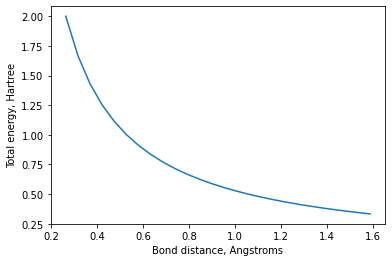

In [78]:
distances =[i*0.1 for i in range(5,31)] # in Bohr radius (atomic unit)
molecule_coordinates = [[[0.0, 0.0, 0.0],[0.0, 0.0, distance]] for distance in distances]
total_energies= []
#molecul_coordinates - 
#print(molecule_coordinates)

for molecule_coordinate in molecule_coordinates:
    H1_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, molecule_coordinate[0],0,0,0)
    H1_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, molecule_coordinate[0],0,0,0)
    H1_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, molecule_coordinate[0],0,0,0)
    
    # 2 atom with displacement 1.4 nm
    H2_pg1a = primitive_gaussian(0.3425250914E+01, 0.1543289673E+00, molecule_coordinate[1],0,0,0)  #1.2 displacment in x direction
    H2_pg1b = primitive_gaussian(0.6239137298E+00, 0.5353281423E+00, molecule_coordinate[1],0,0,0)
    H2_pg1c = primitive_gaussian(0.1688554040E+00, 0.4446345422E+00, molecule_coordinate[1],0,0,0)
    number_occupied_lrbitals = 1
    Z=[1.0, 1.0]
    atom_coordinates=[np.array(molecule_coordinate[0]), np.array(molecule_coordinate[1])] # first array is zeros=origin

    H1_1s = [H1_pg1a,H1_pg1b ,H1_pg1c]    # 1s orbital 1-Hydrogen atom consist of 3 primitive gaussianes
    

    H2_1s = [H2_pg1a,H2_pg1b ,H2_pg1c]    # 1s orbital 2-Hydrogen atom 3 primitive gaussianes
    molecule = [H1_1s,H2_1s] # molecule with two basis function for 1s orbitals
    #-----------------------------------------------
    S = overlap(molecule)
    T = kinetic(molecule)
    Vne = electron_nuclear_attraction(molecule,atom_coordinates ,Z)
    Vee = electron_electron_repultion(molecule)
    Enn = nuclear_nuclear_repulsion_energy(atom_coordinates, Z)
    molecular_terms = [S,T, Vne, Vee]
    scf_parameters = [1e-5, 20] #TOLERANCE, number of steps=20
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    total_energy = electronic_energy+Enn
    total_energies.append(total_energy)
    # compute scf energy (electronic energy)
    # compute total energy-electronic energy+Enn
    # 
    
import matplotlib.pyplot as plt
plt.xlabel("Bond distance, Angstroms")
plt.ylabel("Total energy, Hartree")
plt.plot(np.array(distances)*0.529, total_energies)

In [8]:
'''
print(f"molecule i={i} j={k}-- molecule j={j} i={l}")
molecule i=0 j=0-- molecule j=0 i=0
molecule i=0 j=0-- molecule j=0 i=1
molecule i=0 j=0-- molecule j=0 i=2
molecule i=0 j=1-- molecule j=0 i=0
molecule i=0 j=1-- molecule j=0 i=1
molecule i=0 j=1-- molecule j=0 i=2
molecule i=0 j=2-- molecule j=0 i=0
molecule i=0 j=2-- molecule j=0 i=1
molecule i=0 j=2-- molecule j=0 i=2
molecule i=0 j=0-- molecule j=1 i=0
molecule i=0 j=1-- molecule j=1 i=0
molecule i=0 j=2-- molecule j=1 i=0
molecule i=0 j=0-- molecule j=2 i=0
molecule i=0 j=0-- molecule j=2 i=1
molecule i=0 j=0-- molecule j=2 i=2
molecule i=0 j=1-- molecule j=2 i=0
molecule i=0 j=1-- molecule j=2 i=1
molecule i=0 j=1-- molecule j=2 i=2
molecule i=0 j=2-- molecule j=2 i=0
molecule i=0 j=2-- molecule j=2 i=1
molecule i=0 j=2-- molecule j=2 i=2
molecule i=0 j=0-- molecule j=3 i=0
molecule i=0 j=1-- molecule j=3 i=0
molecule i=0 j=2-- molecule j=3 i=0
molecule i=1 j=0-- molecule j=0 i=0
molecule i=1 j=0-- molecule j=0 i=1
molecule i=1 j=0-- molecule j=0 i=2
molecule i=1 j=0-- molecule j=1 i=0
molecule i=1 j=0-- molecule j=2 i=0
molecule i=1 j=0-- molecule j=2 i=1
molecule i=1 j=0-- molecule j=2 i=2
molecule i=1 j=0-- molecule j=3 i=0
molecule i=2 j=0-- molecule j=0 i=0
molecule i=2 j=0-- molecule j=0 i=1
molecule i=2 j=0-- molecule j=0 i=2
molecule i=2 j=1-- molecule j=0 i=0
molecule i=2 j=1-- molecule j=0 i=1
molecule i=2 j=1-- molecule j=0 i=2
molecule i=2 j=2-- molecule j=0 i=0
molecule i=2 j=2-- molecule j=0 i=1
molecule i=2 j=2-- molecule j=0 i=2
molecule i=2 j=0-- molecule j=1 i=0
molecule i=2 j=1-- molecule j=1 i=0
molecule i=2 j=2-- molecule j=1 i=0
molecule i=2 j=0-- molecule j=2 i=0
molecule i=2 j=0-- molecule j=2 i=1
molecule i=2 j=0-- molecule j=2 i=2
molecule i=2 j=1-- molecule j=2 i=0
molecule i=2 j=1-- molecule j=2 i=1
molecule i=2 j=1-- molecule j=2 i=2
molecule i=2 j=2-- molecule j=2 i=0
molecule i=2 j=2-- molecule j=2 i=1
molecule i=2 j=2-- molecule j=2 i=2
molecule i=2 j=0-- molecule j=3 i=0
molecule i=2 j=1-- molecule j=3 i=0
molecule i=2 j=2-- molecule j=3 i=0
molecule i=3 j=0-- molecule j=0 i=0
molecule i=3 j=0-- molecule j=0 i=1
molecule i=3 j=0-- molecule j=0 i=2
molecule i=3 j=0-- molecule j=1 i=0
molecule i=3 j=0-- molecule j=2 i=0
molecule i=3 j=0-- molecule j=2 i=1
molecule i=3 j=0-- molecule j=2 i=2
molecule i=3 j=0-- molecule j=3 i=0
'''

'\nprint(f"molecule i={i} j={k}-- molecule j={j} i={l}")\nmolecule i=0 j=0-- molecule j=0 i=0\nmolecule i=0 j=0-- molecule j=0 i=1\nmolecule i=0 j=0-- molecule j=0 i=2\nmolecule i=0 j=1-- molecule j=0 i=0\nmolecule i=0 j=1-- molecule j=0 i=1\nmolecule i=0 j=1-- molecule j=0 i=2\nmolecule i=0 j=2-- molecule j=0 i=0\nmolecule i=0 j=2-- molecule j=0 i=1\nmolecule i=0 j=2-- molecule j=0 i=2\nmolecule i=0 j=0-- molecule j=1 i=0\nmolecule i=0 j=1-- molecule j=1 i=0\nmolecule i=0 j=2-- molecule j=1 i=0\nmolecule i=0 j=0-- molecule j=2 i=0\nmolecule i=0 j=0-- molecule j=2 i=1\nmolecule i=0 j=0-- molecule j=2 i=2\nmolecule i=0 j=1-- molecule j=2 i=0\nmolecule i=0 j=1-- molecule j=2 i=1\nmolecule i=0 j=1-- molecule j=2 i=2\nmolecule i=0 j=2-- molecule j=2 i=0\nmolecule i=0 j=2-- molecule j=2 i=1\nmolecule i=0 j=2-- molecule j=2 i=2\nmolecule i=0 j=0-- molecule j=3 i=0\nmolecule i=0 j=1-- molecule j=3 i=0\nmolecule i=0 j=2-- molecule j=3 i=0\nmolecule i=1 j=0-- molecule j=0 i=0\nmolecule i=1 j=0-